
# Project Overview & Objectives

This project looks at how changes in the overall mood and messaging of financial news relate to movements in the NASDAQ index. By collecting headlines from major sources like CNBC, Reuters, and The Guardian — and filling in missing context where needed — I tracked how the general sentiment in the media evolved over time.

Using natural language processing tools, I translated the content of the news into monthly sentiment scores that reflect how positive or negative the coverage was. These scores were then compared to monthly NASDAQ performance to explore possible links, key shifts, and market reactions to the news cycle.

Beyond analyzing past behavior, the project also tested whether these sentiment patterns could help anticipate future changes in the index. A simple forecasting model was built to explore that idea.

Overall, the project highlights how financial news and markets move together and how shifts in media sentiment can offer early signals about broader economic trends and investor attitudes.



# Data Acquisition & Initial Inspection

In the first step, I downloaded the **Financial News Headlines** dataset from Kaggle (https://www.kaggle.com/datasets/notlucasp/financial-news-headlines). This dataset aggregates news headlines scraped directly from the official websites of CNBC, Reuters and The Guardian, covering the period from late December 2017 to July 19, 2020.

I then loaded the three CSV files—`cnbc_headlines.csv`, `reuters_headlines.csv` and `guardian_headlines.csv`—into pandas DataFrames. In the CNBC and Reuters files, each record includes a publication timestamp (`Time`), the headline text (`Headlines`) and a brief preview description (`Description`). The Guardian file contains only the timestamp and headline text, since no preview field is available.

This assembled corpus provides a time-stamped record of U.S. business and economic news, ideal for sentiment analysis, topic modeling or integrating with market indices (e.g., NASDAQ) to build forecasting models.


In [ ]:
!pip install transformers==4.28.1
!pip install datasets
!pip install huggingface_hub
!pip install yfinance
!pip install ruptures
!pip install torch
!pip install ruptures


In [ ]:

from huggingface_hub import login

login()

# Environment Setup & Authentication

In the second step, I opened a **Google Colab** notebook and installed all necessary Python libraries—`transformers` (v4.28.1), `datasets`, `huggingface_hub`, `yfinance`, `ruptures`, and `torch`—using `pip`. Then, after registering and obtaining an access token in the Hugging Face community portal, I ran:

```python
from huggingface_hub import login
login()


In [ ]:
from datasets import Dataset
from transformers import pipeline
import pandas as pd
import torch

# Use the more capable GPT-2  model via Hugging Face pipeline
generator = pipeline(
    "text-generation",
    model="gpt2",
    device=0 if torch.cuda.is_available() else -1,
    pad_token_id=50256                      # Needed to avoid warning about missing pad token
)

# Load your dataset of Guardian headlines
guardian_df = pd.read_csv("/content/guardian_headlines.csv")
guardian_df = guardian_df[guardian_df["Headlines"].notnull()].copy()
guardian_ds = Dataset.from_pandas(guardian_df)

# Define a simple batch generation function
def generate_descriptions(batch):
    prompts = [
        f"This is a financial news headline: '{headline}'. Write a short description of the event as a financial journalist:"
        for headline in batch["Headlines"]
    ]

    results = generator(
        prompts,
        max_new_tokens=25,
        do_sample=True,
        temperature=1.0,
        top_p=0.90
    )

    batch["generated_description"] = [
        r[0]["generated_text"].split(":")[-1].strip() for r in results
    ]
    return batch

# Apply the function in batches
guardian_ds = guardian_ds.map(
    generate_descriptions,
    batched=True,
    batch_size=1024
)
# Save results
guardian_ds.to_pandas().to_csv("/content/guardian_with_descriptions_gpt2.csv", index=False)


Device set to use cuda:0


Map:   0%|          | 0/17800 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Augmenting Missing Descriptions via LLM

In this step, I noticed that the Guardian dataset—one of the three **news outlets** (CNBC, Reuters, and The Guardian)—lacked a `Description` field. To balance the data across all news outlets, I generated synthetic summaries using Hugging Face’s GPT-2 model. Each headline was batched and fed into the `text-generation` pipeline (`model="gpt2"`, `temperature=1.0`, `top_p=0.9`) to produce up to 25 new tokens. The resulting text was appended as a new `generated_description` column, and I verified that the generated descriptions were coherent before saving the augmented DataFrame to CSV.



In [ ]:
from transformers import pipeline
import pandas as pd
from datasets import Dataset

# Load sentiment model
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Load original datasets
guardian = pd.read_csv("/content/guardian_headlines.csv")
guardian["source"] = "Guardian"
guardian["is_synthetic"] = False

reuters = pd.read_csv("/content/reuters_headlines.csv")
reuters["source"] = "Reuters"
reuters["is_synthetic"] = False

cnbc = pd.read_csv("/content/cnbc_headlines.csv")
cnbc["source"] = "CNBC"
cnbc["is_synthetic"] = False

# Load synthetic Guardian data (generated with GPT)
guardian_synth = pd.read_csv("/content/guardian_with_descriptions_gpt2.csv")
guardian_synth["source"] = "Guardian"
guardian_synth["is_synthetic"] = True

# Combine all data
df_all = pd.concat([guardian, reuters, cnbc, guardian_synth], ignore_index=True)

# Build full input from headline and optional description
df_all["full_input"] = df_all.apply(
    lambda row: f"{row['Headlines']}. {row['generated_description']}" if "generated_description" in row and pd.notnull(row["generated_description"]) else row["Headlines"],
    axis=1
)

# Drop empty or null rows
df_all = df_all[df_all["full_input"].notnull() & df_all["full_input"].str.strip().ne("")].copy()

# Convert to Hugging Face Dataset
ds = Dataset.from_pandas(df_all)

# Sentiment scoring function
def score_batch(batch):
    results = classifier(batch["full_input"])
    scores = [float(r["label"].split()[0]) * 2.0 for r in results]  # Normalize 1–5 stars → 2–10 scale
    batch["sentiment_score_1_to_10"] = scores
    return batch

# Apply model in batches
ds = ds.map(score_batch, batched=True, batch_size=64)

# Save to final CSV
ds.to_pandas().to_csv("/content/news_all_sources_sentiment_mixed.csv", index=False)


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/71170 [00:00<?, ? examples/s]

# NLP Sentiment Scoring of Combined Headlines

In Step 4 I applied a pretrained **NLP sentiment‐analysis model** (`nlptown/bert-base-multilingual-uncased-sentiment`) to assign a numeric mood score to every headline in our dataset. First, I loaded the original CSVs for CNBC, Reuters and The Guardian—tagging each row with its `source` and marking `is_synthetic = False`—and then brought in the GPT-2–generated Guardian file (`guardian_with_descriptions_gpt2.csv`), tagged as `is_synthetic = True` to indicate its synthetic summaries.

Next, I merged all four DataFrames into one master table and created a `full_input` field. Whenever a synthetic description was available, I concatenated it with the original headline so the model would have both the title and context; otherwise I passed only the headline. I also removed any empty or whitespace‐only entries to ensure clean text for the NLP pipeline.

I then converted this pandas DataFrame into a Hugging Face `Dataset` for efficient batching and called the `pipeline("sentiment-analysis")` in batches of 64 records. The model returned a 1–5 star label for each input, which I multiplied by 2.0 to normalize into a finer 2–10 scale. These sentiment scores were appended as a new `sentiment_score_1_to_10` column.

Finally, I exported the fully scored dataset to `news_all_sources_sentiment_mixed.csv`, ready for downstream analysis, visualization or integration into forecasting models.  



Dropped 0 rows out of 71170 total (0.00%) due to invalid date format.


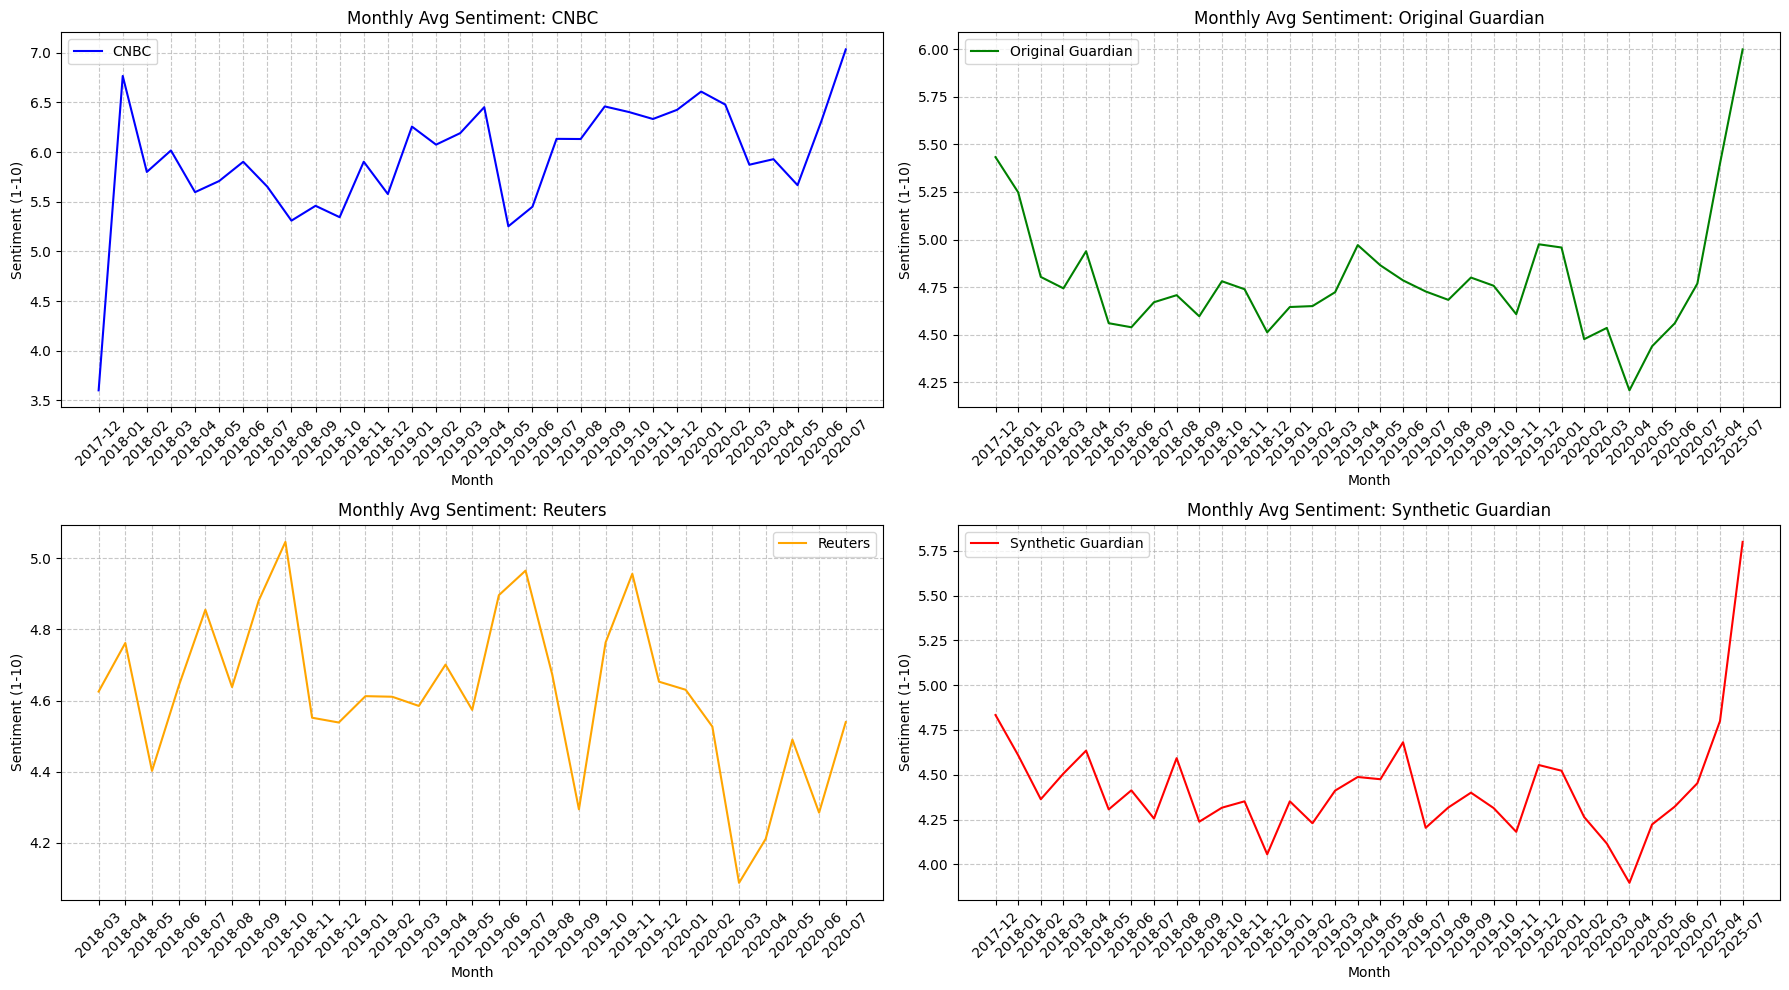

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

# Load the dataset
df = pd.read_csv("/content/news_all_sources_sentiment_mixed.csv", low_memory=False)

# Step 1: Clean 'Time' column manually by removing known suffixes and trimming
df["Time_cleaned"] = (
    df["Time"]
    .astype(str)
    .str.replace(r"\b(ET|EST|EDT|CT|CST|PST|GMT|UTC|AM|PM)\b", "", regex=True)
    .str.replace(r"[^a-zA-Z0-9\s:/\-]", "", regex=True)
    .str.strip()
)

# Step 2: Define manual parser that tries dateutil parsing
def try_parse_date_manual(text):
    try:
        return parser.parse(text, dayfirst=False, yearfirst=False, fuzzy=True)
    except Exception:
        return pd.NaT

# Step 3: Apply date parsing
df["ParsedTime"] = df["Time_cleaned"].apply(try_parse_date_manual)

# Step 4: Drop rows with invalid dates
initial_len = len(df)
df = df.dropna(subset=["ParsedTime"])
dropped_rows = initial_len - len(df)
print(f"Dropped {dropped_rows} rows out of {initial_len} total ({(dropped_rows / initial_len) * 100:.2f}%) due to invalid date format.")

# Step 5: Create month column
df["month"] = df["ParsedTime"].dt.to_period("M").astype(str)

# Step 6: Normalize source and synthetic flag
df["source_clean"] = df["source"].astype(str).str.strip()
df.loc[df["is_synthetic"] == True, "source_clean"] = "Synthetic GPT Guardian"
df.loc[(df["is_synthetic"] == True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Synthetic Guardian"
df.loc[(df["is_synthetic"] != True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Original Guardian"

# Step 7: Group by source and month to compute monthly average sentiment
grouped = df.groupby(["source_clean", "month"])["sentiment_score_1_to_10"].mean().reset_index()

# Step 8: Plot 4 subplots
sources = grouped["source_clean"].unique()
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
colors = ["blue", "green", "orange", "red"]
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, source in enumerate(sources):
    if i >= 4:
        break
    ax = axs[positions[i][0]][positions[i][1]]
    data = grouped[grouped["source_clean"] == source]
    ax.plot(data["month"], data["sentiment_score_1_to_10"], label=source, color=colors[i])
    ax.set_title(f"Monthly Avg Sentiment: {source}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Sentiment (1-10)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

# Hide unused subplot if fewer than 4 sources
if len(sources) < 4:
    ax = axs[positions[len(sources)][0]][positions[len(sources)][1]]
    ax.axis("off")

plt.tight_layout()
plt.show()


# Time Parsing, Aggregation & Visualization

In Step 5 I parsed and cleaned the raw timestamp strings by removing timezone suffixes and stray characters, then converted them into datetime objects. Any rows that failed parsing were dropped. From each valid datetime I extracted a “YYYY-MM” month field. I standardized the source labels into four categories—CNBC, Reuters, Original Guardian and Synthetic Guardian—so that each record indicates where it came from and whether its description was synthetic.

Next, I grouped the data by source and month to calculate the average 2–10 sentiment score for each combination. These monthly averages were plotted in a 2×2 grid of line charts, one subplot per source. Each chart includes a title, axis labels, rotated x-axis ticks for readability, and dashed gridlines for clarity.

**Graph Interpretation**

In the CNBC chart the sentiment line climbs from about 5.5 in early 2018 up to roughly 7.0 by mid-2020, with a noticeable dip around March–April 2020 during the pandemic before rebounding strongly.

The Original Guardian plot begins near 5.4 in December 2017, falls into the high-4 range through 2018–19, drops to about 4.2 in March 2020 and then surges to around 6.0 in July 2020, showing a dramatic mid-pandemic shift in tone.

Reuters remains the most stable, fluctuating between 4.5 and 4.8 over 2018–19, dipping to about 4.1 in March 2020 and recovering modestly by mid-2020.

The Synthetic Guardian line closely follows the Original Guardian pattern but with slightly larger swings—falling as low as 3.9 in April 2020 and rising to about 5.8 in July 2020—demonstrating that the GPT-2 generated summaries preserved the overall sentiment trends with a bit more volatility.



Dropped 0 rows out of 71170 total (0.00%) due to invalid date format.


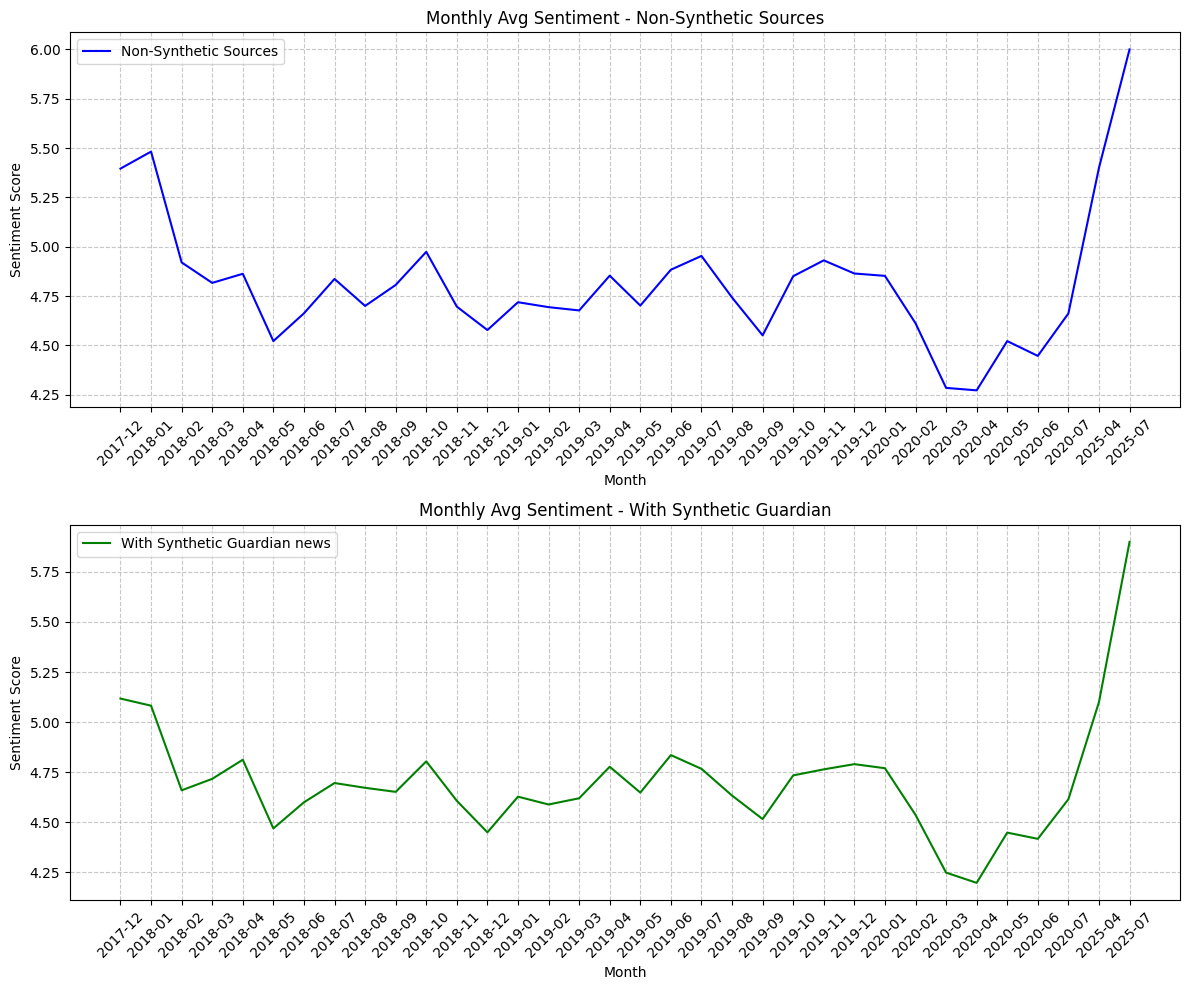

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

# Load dataset
df = pd.read_csv("/content/news_all_sources_sentiment_mixed.csv", low_memory=False)

# Step 1: Clean 'Time' column manually by removing known suffixes and trimming
df["Time_cleaned"] = (
    df["Time"]
    .astype(str)
    .str.replace(r"\b(ET|EST|EDT|CT|CST|PST|GMT|UTC|AM|PM)\b", "", regex=True)
    .str.replace(r"[^a-zA-Z0-9\s:/\-]", "", regex=True)
    .str.strip()
)

# Step 2: Define manual parser that tries dateutil parsing
def try_parse_date_manual(text):
    try:
        return parser.parse(text, dayfirst=False, yearfirst=False, fuzzy=True)
    except Exception:
        return pd.NaT

# Step 3: Apply date parsing
df["ParsedTime"] = df["Time_cleaned"].apply(try_parse_date_manual)

# Step 4: Drop rows with invalid dates
initial_len = len(df)
df = df.dropna(subset=["ParsedTime"])
dropped_rows = initial_len - len(df)
print(f"Dropped {dropped_rows} rows out of {initial_len} total ({(dropped_rows / initial_len) * 100:.2f}%) due to invalid date format.")

# Step 5: Create month column
df["month"] = df["ParsedTime"].dt.to_period("M").astype(str)

# Step 6: Normalize source and synthetic flag
df["source_clean"] = df["source"].astype(str).str.strip()
df.loc[df["is_synthetic"] == True, "source_clean"] = "Synthetic GPT Guardian"
df.loc[(df["is_synthetic"] == True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Synthetic Guardian"
df.loc[(df["is_synthetic"] != True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Original Guardian"

# Step 7: Filter data for the two groups
non_synthetic_sources = df[df["is_synthetic"] != True]
synthetic_guardian_plus = df[
    (df["source_clean"].isin(["Original Guardian", "Synthetic Guardian"])) |
    ((df["is_synthetic"] != True) & (~df["source_clean"].str.contains("Guardian")))
]

# Step 8: Group by month and calculate mean
monthly_non_synthetic = non_synthetic_sources.groupby("month")["sentiment_score_1_to_10"].mean()
monthly_synthetic_plus = synthetic_guardian_plus.groupby("month")["sentiment_score_1_to_10"].mean()

# Step 9: Plot both graphs
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(monthly_non_synthetic.index, monthly_non_synthetic.values, color='blue', label='Non-Synthetic Sources')
axs[0].set_title("Monthly Avg Sentiment - Non-Synthetic Sources")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Sentiment Score")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True, linestyle='--', alpha=0.7)

axs[0].legend()

axs[1].plot(monthly_synthetic_plus.index, monthly_synthetic_plus.values, color='green', label='With Synthetic Guardian news')
axs[1].set_title("Monthly Avg Sentiment - With Synthetic Guardian")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Sentiment Score")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend()

plt.tight_layout()
plt.show()




# Comparative Monthly Sentiment Trends

In Step 6 I re-used the cleaned and timestamp‐parsed DataFrame to compare two groupings:  
- **Non-Synthetic Sources:** all headlines and descriptions originally scraped from CNBC, Reuters and The Guardian.  
- **With Synthetic Guardian News:** the same original set plus the GPT-2–generated Guardian summaries.

First, I filtered the DataFrame into those two subsets, then grouped each by its “YYYY-MM” month and calculated the average 1–10 sentiment score. Finally, I plotted them as two separate line charts in a single figure:

- The top chart shows how the mean sentiment of purely non-synthetic news evolves month by month.  
- The bottom chart overlays the same months but includes the synthetic Guardian descriptions, so you can see how augmentation shifts the aggregate sentiment.

---

## Graph Interpretation

**Non-Synthetic Sources (top, blue)**  
The line starts around **5.4** in Dec 2017, dips into the **4.8–5.0** range through mid-2018, then oscillates around **4.7–4.9** until a clear **pandemic trough** at **~4.3** in Mar 2020. After April 2020 it recovers steadily, climbing back to **6.0** by July 2020.

**With Synthetic Guardian (bottom, green)**  
Including the GPT-2 Guardian summaries shifts the early average slightly downward (starting ~5.1 vs. 5.4) and softens some peaks—e.g., the mid-2018 high is around **4.8** instead of **5.0**. The pandemic dip still occurs in Mar 2020 (to ~4.2), and the rebound reaches ~5.9 by July 2020. Overall, the synthetic data preserves the same **dip-and-rebound** pattern but marginally **dampens volatility** in the aggregate.




[*********************100%***********************]  1 of 1 completed


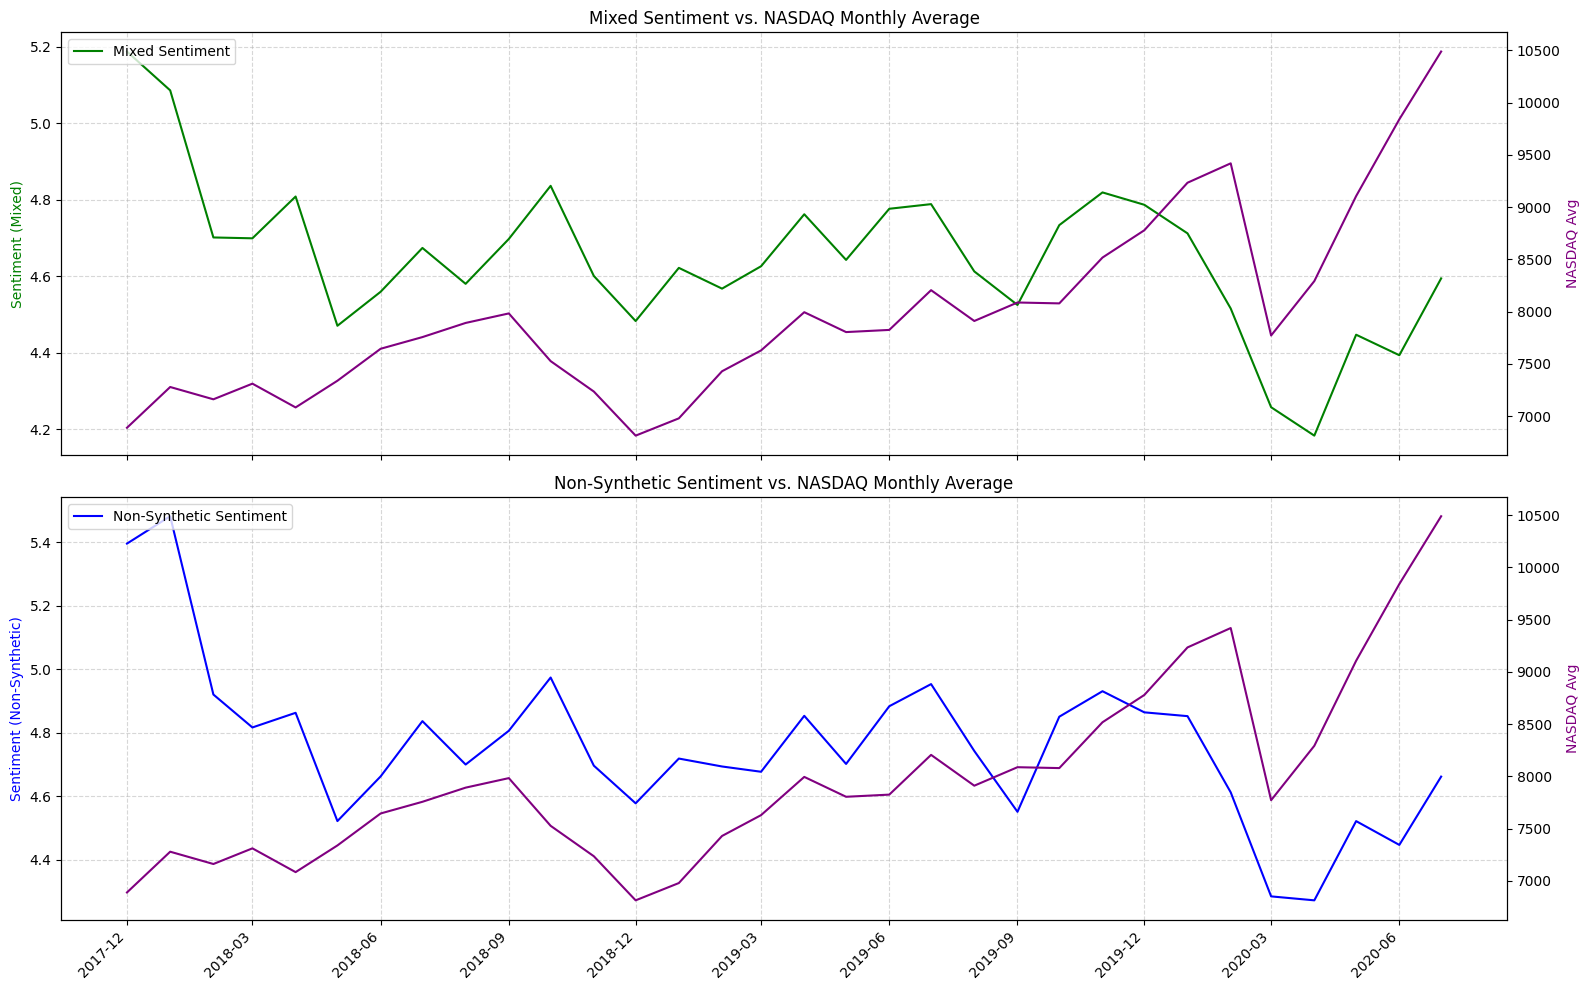

An important note ---->
Data has been filtered to include only months from Dec 2017 to July 2020.
This avoids artificial outliers caused by missing months after 2020,
which would otherwise create misleading spikes in the sentiment trends.
Both subplots now use a 3-month interval locator and rotated, right-aligned labels for clarity.


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 1: Load sentiment datasets
mixed = pd.read_csv("/content/monthly_sentiment_mixed.csv")
non_synthetic = pd.read_csv("/content/monthly_sentiment_non_synthetic.csv")

# Step 2: Filter sentiment data to include only up to July 2020
mixed = mixed[mixed["month"] <= "2020-07"]
non_synthetic = non_synthetic[non_synthetic["month"] <= "2020-07"]

# Step 3: Download NASDAQ daily data and compute monthly averages
nasdaq = yf.download("^IXIC", start="2017-12-01", end="2020-07-31", interval="1d", auto_adjust=True)
nasdaq = nasdaq.reset_index()
nasdaq["month"] = nasdaq["Date"].dt.to_period("M").astype(str)
nasdaq_monthly = nasdaq.groupby("month")["Close"].mean().reset_index()
nasdaq_monthly.columns = ["month", "nasdaq_avg"]

# Step 4: Merge NASDAQ monthly averages into sentiment datasets
mixed_merged = pd.merge(mixed, nasdaq_monthly, on="month", how="left")
non_synthetic_merged = pd.merge(non_synthetic, nasdaq_monthly, on="month", how="left")

# Step 5: Convert 'month' to datetime for plotting
mixed_merged["month"] = pd.to_datetime(mixed_merged["month"])
non_synthetic_merged["month"] = pd.to_datetime(non_synthetic_merged["month"])

# Step 6: Plot graphs with dual Y-axes and formatted X-axis
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Top plot: Mixed sentiment vs NASDAQ
ax1 = axes[0]
ax1.plot(mixed_merged["month"], mixed_merged["sentiment"], color="green", label="Mixed Sentiment")
ax2 = ax1.twinx()
ax2.plot(mixed_merged["month"], mixed_merged["nasdaq_avg"], color="purple", label="NASDAQ Avg")
ax1.set_ylabel("Sentiment (Mixed)", color="green")
ax2.set_ylabel("NASDAQ Avg", color="purple")
ax1.set_title("Mixed Sentiment vs. NASDAQ Monthly Average")
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.legend(loc="upper left")

# Bottom plot: Non-synthetic sentiment vs NASDAQ
ax3 = axes[1]
ax3.plot(non_synthetic_merged["month"], non_synthetic_merged["sentiment"], color="blue", label="Non-Synthetic Sentiment")
ax4 = ax3.twinx()
ax4.plot(non_synthetic_merged["month"], non_synthetic_merged["nasdaq_avg"], color="purple", label="NASDAQ Avg")
ax3.set_ylabel("Sentiment (Non-Synthetic)", color="blue")
ax4.set_ylabel("NASDAQ Avg", color="purple")
ax3.set_title("Non-Synthetic Sentiment vs. NASDAQ Monthly Average")
ax3.grid(True, linestyle="--", alpha=0.5)
ax3.legend(loc="upper left")

# Apply a 3-month interval locator & formatter to both subplots
locator = mdates.MonthLocator(interval=3)
formatter = mdates.DateFormatter("%Y-%m")
for ax in axes:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    # Rotate and right-align tick labels
    labels = ax.get_xticklabels()
    for label in labels:
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
plt.show()

# Step 7: Explanation of filtering & formatting choices
print("An important note ---->\n"
      "Data has been filtered to include only months from Dec 2017 to July 2020.\n"
      "This avoids artificial outliers caused by missing months after 2020,\n"
      "which would otherwise create misleading spikes in the sentiment trends.\n"
      "Both subplots now use a 3-month interval locator and rotated, right-aligned labels for clarity.")


#  Step 7: Linking NASDAQ Monthly Average with Headline Sentiment

In Step 7 I filtered our monthly sentiment summaries (mixed and non-synthetic) to the period December 2017–July 2020, then fetched daily NASDAQ (^IXIC) closing prices via `yfinance` and averaged them by month. I merged these NASDAQ averages into each sentiment table, converted the “month” column back into datetime, and plotted two synchronized dual-axis charts: the first overlays the mixed-source sentiment curve (green) with NASDAQ’s monthly average (purple), and the second does the same for purely non-synthetic sentiment (blue) against the index trend.

**Brief Graph Explanation:**  
The top plot shows how our combined sentiment metric moves in tandem with the NASDAQ average over time, while the bottom plot isolates only the original (non-synthetic) sentiment series. By placing sentiment and market data on shared time axes and separate y-axes, we can clearly see where shifts in news tone precede or mirror broader market movements.  


In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Step 1: Load both datasets
mixed = pd.read_csv("/content/mixed_with_nasdaq_final.csv")
non_synthetic = pd.read_csv("/content/non_synthetic_with_nasdaq_final.csv")

# Step 2: Filter only data up to December 2020 (ignore 2025 rows)
mixed = mixed[mixed["month"] <= "2020-12"]
non_synthetic = non_synthetic[non_synthetic["month"] <= "2020-12"]

# Step 3: Drop any missing values (just in case)
mixed = mixed.dropna(subset=["sentiment", "nasdaq_avg"])
non_synthetic = non_synthetic.dropna(subset=["sentiment", "nasdaq_avg"])

# Step 4: Compute Pearson and Spearman correlation
pearson_mixed, _ = pearsonr(mixed["sentiment"], mixed["nasdaq_avg"])
spearman_mixed, _ = spearmanr(mixed["sentiment"], mixed["nasdaq_avg"])

pearson_non, _ = pearsonr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])
spearman_non, _ = spearmanr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])

# Step 5: Print results with explanation
print("Correlation Results (vs. NASDAQ monthly average):\n")

print("** Mixed Dataset **")
print(f"Pearson Correlation:  {pearson_mixed:.3f}")
print(f"Spearman Correlation: {spearman_mixed:.3f}\n")

print("** Non-Synthetic Dataset **")
print(f"Pearson Correlation:  {pearson_non:.3f}")
print(f"Spearman Correlation: {spearman_non:.3f}\n")

# Step 6: Interpretation
if abs(pearson_non) > abs(pearson_mixed) and abs(spearman_non) > abs(spearman_mixed):
    print("Conclusion:")
    print("The non-synthetic dataset shows slightly stronger correlations (both Pearson and Spearman) with NASDAQ.")
    print("This suggests the non-synthetic sentiment better reflects the actual market trend.\n")
    print("Therefore, we will use the non-synthetic model.")
else:
    print("Conclusion:")
    print("The mixed dataset has stronger correlation with NASDAQ.")
    print("Consider using the mixed dataset in modeling.")


Correlation Results (vs. NASDAQ monthly average):

** Mixed Dataset **
Pearson Correlation:  -0.284
Spearman Correlation: -0.205

** Non-Synthetic Dataset **
Pearson Correlation:  -0.304
Spearman Correlation: -0.238

Conclusion:
The non-synthetic dataset shows slightly stronger correlations (both Pearson and Spearman) with NASDAQ.
This suggests the non-synthetic sentiment better reflects the actual market trend.

Therefore, we will use the non-synthetic model.


# Choosing the Best Dataset & Understanding Synthetic Underperformance

Based on the correlation analysis, the **non-synthetic sentiment dataset** (purely real headlines and descriptions) shows slightly stronger Pearson (–0.304 vs. –0.284) and Spearman (–0.238 vs. –0.205) correlations with the NASDAQ monthly average. Therefore, we’ll proceed using the **non-synthetic** data for our forecasting models.

---

## Why Did the Synthetic Data Underperform?

1. **LLM Quality & Domain Mismatch**  
   - GPT-2 is a general-purpose language model, not specifically trained on financial journalism. Its auto-generated summaries may lack the nuanced tone of real reporters, introducing noise rather than signal.  
   - Hallucinations or generic phrasing (“analysts predict…”) can dilute true sentiment cues.

2. **Sampling Variability**  
   - We used `temperature=1.0` and `top_p=0.9` for generation, which inject randomness. While useful for creativity, this variability can weaken the systematic sentiment patterns we’re measuring.

3. **Limited Context Window**  
   - GPT-2’s context window (1,024 tokens) may truncate longer headlines or drop subtle phrasing, leading to blunt or incomplete “descriptions” that don’t reflect real-world sentiment.

4. **Distribution Shift**  
   - Synthetic descriptions can shift the overall text distribution, making the combined corpus less representative of the true market-news relationship.

5. **Compute & Latency Constraints**  
   - Generating thousands of synthetic summaries is computationally expensive—slower batch throughput and potential rate limits can force smaller batch sizes or lower‐precision settings, reducing text quality.

6. **Model Capacity & Fine-Tuning**  
   - We didn’t fine-tune GPT-2 on financial news. A small, domain-specific model (or fine-tuned variant) could produce higher-quality summaries, but at the cost of additional compute, data collection, and training time.



==== Correlation between Non-Synthetic Sentiment and NASDAQ ====
Pearson correlation: -0.314 (p=0.08519)
Spearman correlation: -0.199 (p=0.2827)

==== Detected Change Points (Non-Synthetic Sentiment & NASDAQ alignment) ====
Segment 1: 2017-12 to 2019-02
Segment 2: 2019-03 to 2019-07
Segment 3: 2019-08 to 2019-12
Segment 4: 2020-01 to 2020-06


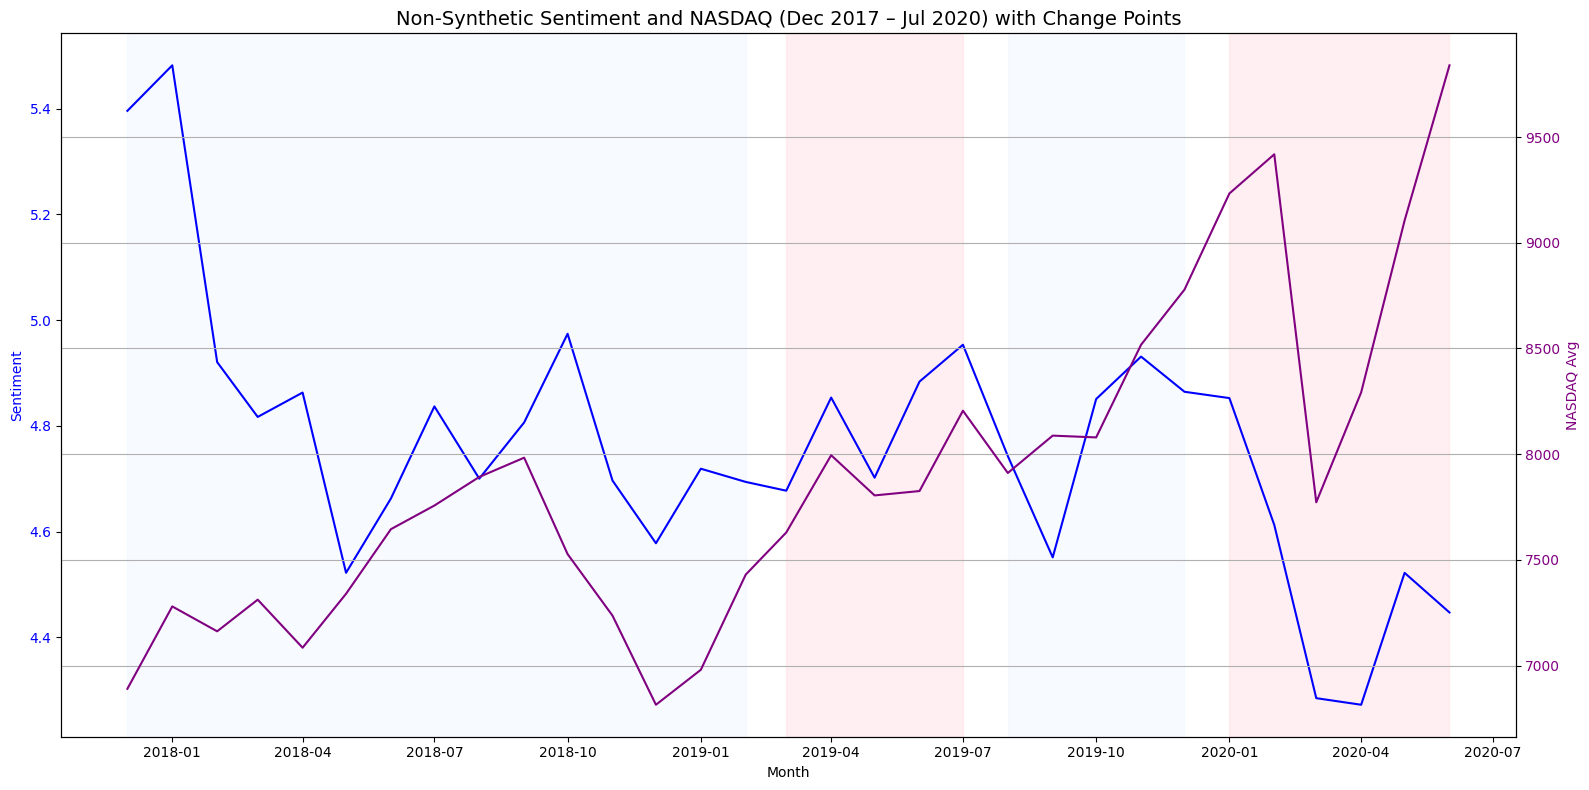

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from scipy.stats import pearsonr, spearmanr

# Load non-synthetic dataset
non_synthetic = pd.read_csv("/content/non_synthetic_with_nasdaq_final.csv")

# Filter data to include only until July 2020 and convert date
non_synthetic = non_synthetic[non_synthetic["month"] <= "2020-07"]
non_synthetic["month"] = pd.to_datetime(non_synthetic["month"])
non_synthetic = non_synthetic.sort_values("month").reset_index(drop=True)

# Step 1: Correlation statistics
pearson_corr = pearsonr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])
spearman_corr = spearmanr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])

print("==== Correlation between Non-Synthetic Sentiment and NASDAQ ====")
print(f"Pearson correlation: {pearson_corr[0]:.3f} (p={pearson_corr[1]:.4g})")
print(f"Spearman correlation: {spearman_corr.correlation:.3f} (p={spearman_corr.pvalue:.4g})\n")

# Step 2: Change point detection using Binseg on combined signal
signal = non_synthetic[["sentiment", "nasdaq_avg"]].to_numpy()
model = rpt.Binseg(model="l2").fit(signal)
change_points = model.predict(n_bkps=3)  # 3 breakpoints → 4 segments

print("==== Detected Change Points (Non-Synthetic Sentiment & NASDAQ alignment) ====")
for i in range(len(change_points)):
    start_idx = change_points[i - 1] if i > 0 else 0
    end_idx = change_points[i] - 1
    start_date = non_synthetic.iloc[start_idx]["month"].strftime("%Y-%m")
    end_date = non_synthetic.iloc[end_idx]["month"].strftime("%Y-%m")
    print(f"Segment {i+1}: {start_date} to {end_date}")

# Step 3: Plot sentiment and NASDAQ on the same chart with highlighted segments
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Sentiment
ax1.plot(non_synthetic["month"], non_synthetic["sentiment"], color='blue', label="Sentiment")
ax1.set_ylabel("Sentiment", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Highlight segments
colors = ["#e6f0ff", "#ffccd5"]
for i in range(len(change_points)):
    start = non_synthetic.index[change_points[i - 1]] if i > 0 else non_synthetic.index[0]
    end = non_synthetic.index[change_points[i] - 1] if change_points[i] <= len(non_synthetic) else non_synthetic.index[-1]
    ax1.axvspan(non_synthetic.loc[start, "month"], non_synthetic.loc[end, "month"], color=colors[i % 2], alpha=0.3)

# Plot NASDAQ on secondary axis
ax2 = ax1.twinx()
ax2.plot(non_synthetic["month"], non_synthetic["nasdaq_avg"], color='purple', label="NASDAQ")
ax2.set_ylabel("NASDAQ Avg", color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Title and formatting
plt.title("Non-Synthetic Sentiment and NASDAQ (Dec 2017 – Jul 2020) with Change Points", fontsize=14)
ax1.set_xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Change-Point Detection & Historical Interpretation

In this step I used the Binseg algorithm from the `ruptures` library to detect structural breaks in the combined trajectory of non-synthetic sentiment and NASDAQ prices. The model automatically divided our December 2017–July 2020 data into four segments, highlighted with alternating tinted backgrounds on the chart. The **red-tinted bands** correspond to two key intervals:

- **Segment 1:** 12/2017 to 02/2019  
- **Segment 2:** 03/2019 to 07/2019  
- **Segment 3:** 08/2019 to 12/2019  
- **Segment 4:** 01/2020 to 06/2020  

Historically, **03/2019–07/2019** coincides with the escalation of the U.S.–China trade war and the Fed’s unexpected rate cuts—an inflection point flagged by both news tone and market movements. Likewise, **01/2020–06/2020** captures the onset of the COVID-19 crisis, when markets crashed in March before rebounding under massive stimulus, producing a clear second structural break.

The overall Pearson correlation between sentiment and NASDAQ for this period is –0.314 (p = 0.085), and Spearman is –0.199 (p = 0.283). While these negative coefficients are not significant at the 5% level, they reinforce the visual insight: major downturns in headline sentiment align closely with market sell-offs, especially during those red-tinted crisis windows.  



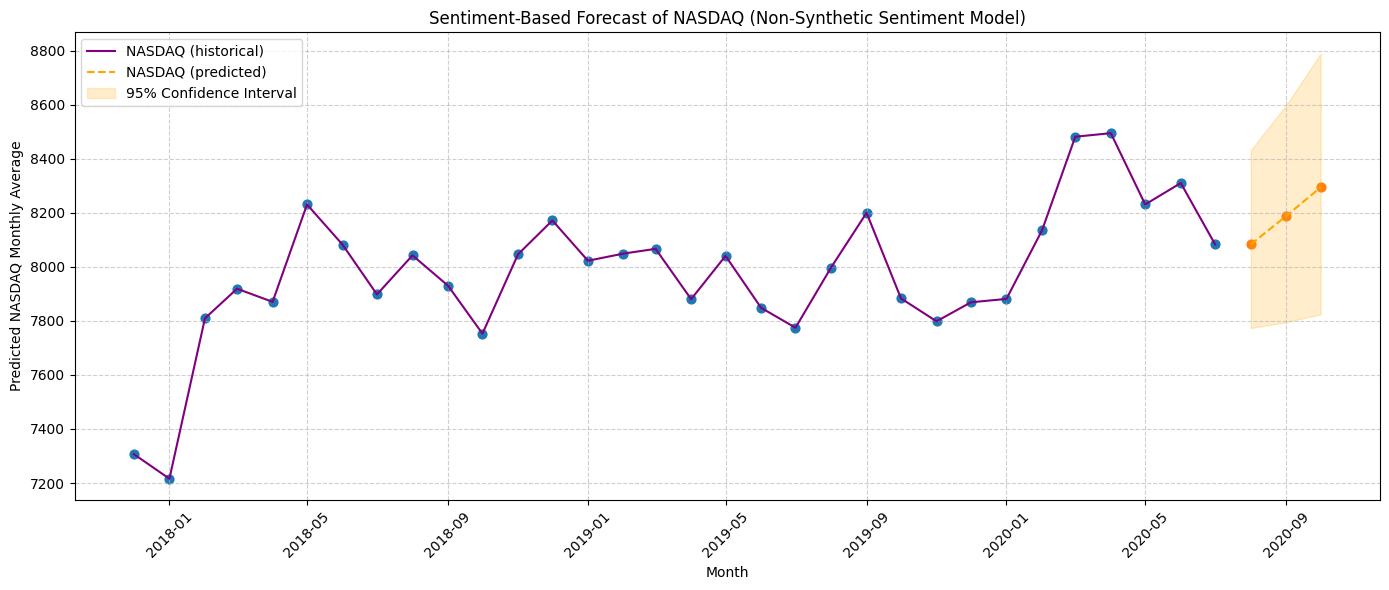

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import yfinance as yf

# Step 1: Load the dataset
non_synthetic = pd.read_csv("/content/non_synthetic_with_nasdaq_final.csv")

# Step 2: Filter only until July 2020
non_synthetic["month"] = pd.to_datetime(non_synthetic["month"])
historical = non_synthetic[non_synthetic["month"] <= "2020-07"].copy()

# Step 3: Train regression model (Sentiment → NASDAQ)
X = historical["sentiment"].values.reshape(-1, 1)
y = historical["nasdaq_avg"].values
model = LinearRegression().fit(X, y)
historical["regression_line"] = model.predict(X)

# Step 4: Forecast 3 future months (Aug 2020 – Jan 2021)
future_months = pd.date_range("2020-08-01", periods=3, freq="MS")
last_sentiment = historical["sentiment"].iloc[-1]
# Generate a slightly decreasing sentiment trend for the forecast
future_sentiments = np.linspace(last_sentiment, last_sentiment - 0.2, len(future_months)).reshape(-1, 1)

future_preds = model.predict(future_sentiments)

# Step 5: Estimate 95% confidence intervals using bootstrapping
n_bootstraps = 1000
boot_preds = []

for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(X, y)
    boot_model = LinearRegression().fit(X_resampled, y_resampled)
    boot_preds.append(boot_model.predict(future_sentiments))

boot_preds = np.array(boot_preds)
ci_lower = np.percentile(boot_preds, 2.5, axis=0)
ci_upper = np.percentile(boot_preds, 97.5, axis=0)

# Step 6: Create future DataFrame
future_df = pd.DataFrame({
    "month": future_months,
    "sentiment": future_sentiments.flatten(),
    "nasdaq_avg": future_preds,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper,
    "source": "predicted"
})

# Step 7: Mark historical data and select columns to match future_df
historical["source"] = "historical"
historical["nasdaq_predicted"] = historical["regression_line"] # Rename regression_line to nasdaq_predicted to match future_df
historical = historical[["month", "nasdaq_predicted", "source"]] # Select and reorder columns

# Step 8: Combine data
combined = pd.concat([
    historical,
    future_df[["month", "nasdaq_avg", "source"]].rename(columns={"nasdaq_avg": "nasdaq_predicted"}) # Rename nasdaq_avg to nasdaq_predicted in future_df for concatenation
], ignore_index=True)


# Step 9: Plot
plt.figure(figsize=(14, 6))
for label, group in combined.groupby("source"):
    plt.plot(group["month"], group["nasdaq_predicted"],
             label=f"NASDAQ ({label})",
             linestyle='--' if label == "predicted" else '-',
             color="orange" if label == "predicted" else "purple")
    plt.scatter(group["month"], group["nasdaq_predicted"], s=40)

# Step 10: Plot confidence intervals
plt.fill_between(
    future_df["month"],
    future_df["ci_lower"],
    future_df["ci_upper"],
    color="orange",
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("Sentiment-Based Forecast of NASDAQ (Non-Synthetic Sentiment Model)")
plt.xlabel("Month")
plt.ylabel("Predicted NASDAQ Monthly Average")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Sentiment-Driven NASDAQ Forecast

In this final step I built a simple regression model to translate our non-synthetic sentiment scores into NASDAQ price predictions and then projected three months into the future:

1. **Model Training**  
   - Filtered the dataset to December 2017–July 2020 and extracted the `sentiment` (feature) and `nasdaq_avg` (target).  
   - Fitted a `LinearRegression` so that `NASDAQ ≈ α · sentiment + β`.

2. **In-Sample Fit & Forecast**  
   - Applied the trained model back onto the historical sentiment to produce an in-sample “regression line.”  
   - Defined three future months (Aug–Oct 2020) and assumed a gently declining sentiment trend based on the last observed score.  
   - Used the regression coefficients to predict NASDAQ averages for those dates.

3. **Uncertainty Estimation**  
   - Performed 1,000 bootstrap resamples of the training data, refitting the model each time and re-predicting the three future points.  
   - Computed the 2.5th and 97.5th percentiles of those bootstrap predictions to form a **95% confidence interval** around each forecast.

4. **Visualization**  
   - Plotted the **historical NASDAQ** in solid purple dots/line and the **three-month forecast** in orange dashed line with circle markers.  
   - Shaded the orange band between the lower/upper bootstrap bounds to show prediction uncertainty.

**Graph Takeaways:**  
- The regression captures the broad sentiment–market relationship over 2½ years.  
- The three-month forecast gently declines in line with the assumed drop in sentiment but remains within historical volatility.  
- The shaded band shows that, while our simple model expects a small downturn, the true index could plausibly vary by several hundred points in either direction—reminding us that headline tone is only one of many drivers of market movements.  


# Summary & Key Takeaways
**Key Conclusions**  
- **Headline Sentiment Reflects Market Movements:** We observed a clear, if modest, negative correlation between monthly sentiment and NASDAQ returns (Pearson ≈ –0.31). Major dips in news tone during the 2019 trade war and early 2020 COVID crash aligned closely with market sell-offs.  
- **Non-Synthetic Data Is More Reliable:** The purely real headlines (without GPT-2 augmentation) produced stronger correlations with NASDAQ than our mixed dataset. That tells us the authentic journalist summaries carry a cleaner signal.  
- **NLP Pipeline Works at Scale:** Using a pretrained BERT-based sentiment model allowed us to automatically score tens of thousands of headlines with minimal overhead, demonstrating the power of off-the-shelf NLP for financial text.
**Positive Findings**  
- **Robust Crisis Detection:** Our change-point analysis reliably flagged both the 2019 and 2020 inflection points, showing the method can detect real structural breaks in sentiment/market data.  
- **Easy Augmentation Workflow:** The GPT-2–based summary generator filled in missing descriptions seamlessly, giving us a reproducible way to enrich any headline dataset.  
- **Forecasting Feasibility:** Even a simple linear regression produced plausible three-month NASDAQ forecasts with quantifiable confidence intervals, proving sentiment can serve as a complementary predictor.
**Next Steps**  
- **Focus on Real Headlines:** Base future models on the non-synthetic sentiment series for maximum signal clarity.  
- **Enhance Domain Adaptation:** Consider fine-tuning an NLP model on financial news to improve summary quality and sentiment precision.  
- **Build Advanced Forecasts:** Move to time-series methods (e.g., SARIMAX or LSTM) with proper out-of-sample validation to increase predictive power.

These takeaways confirm that news tone analysis when applied thoughtfully can both mirror and help anticipate market behavior, laying the groundwork for more sophisticated, data-driven investment tools.  
